#  Business Decision Making
**Customer**

Online store

**Project Objectives**

* The need to prioritize hypotheses from a list of hypotheses provided by the Marketing Department;

* Analysis of the results of the conducted A/B testing and reasoning for the decision based on the test results.

Solution options:
1. Stop the test, record the victory of one of the groups.
2. Stop the test, record no difference between groups.
3. Continue test.

**Input data**

* list of hypotheses (file hypothesis.csv)
Hypothesis — brief description of the hypothesis;
Reach — user reach on a 10-point scale;
Impact —  impact on users on a 10-point scale;
Confidence — confidence in the hypothesis on a 10-point scale;
Efforts — efforts for hypothesis testing on a 10-point scale.

* information about user orders in the online store (file orders.csv.)
transactionId — order ID;
visitorId — ID of the user who made the order;
date — the date the order was placed;
revenue — order revenue;
group — the A/B test group the order is in.

* information about visits by users of the online store (file visitors.csv)
date — date;
group — A/B test group;
visitors — number of users on the specified date in the specified A/B test group.

**Research progress**

The research will take place in three stages:

* Overview and data preprocessing;
* Prioritization of hypotheses;
* A/B test analysis;

# Data overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
from scipy import stats as st

In [2]:
hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )

In [3]:
# overview of the hypothesis dataframe

hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
# overview of the orders dataframe

orders.info()
orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [5]:
# overview of the visitors dataframe 

visitors.info()
visitors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


**Conclusion**

We have looked at the tables. At first glance, there are no gaps, but something needs to be corrected: the data type in the columns is not always correct (for example, columns with dates are of type object). We also need to check the data for duplicates and bring the column names to the same style.

# **Data preprocessing**

In [6]:
# bring the column names to the correct style

hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [name.replace('Id', '_id') for name in orders.columns]

display(hypothesis.columns)
orders.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [7]:
# change data type for date columns

visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [8]:
# check tables for duplicates

display(visitors.duplicated().sum())
orders.duplicated().sum()

0

0

# **Prioritization of hypotheses**

In [9]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False).head(5)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000


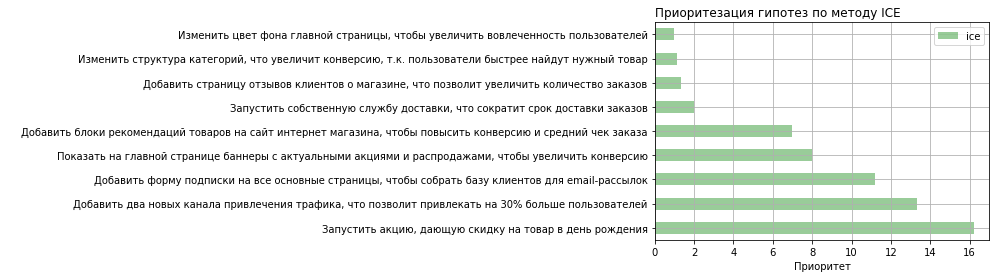

In [10]:
ax = (hypothesis[['hypothesis', 'ice']]
      .set_index('hypothesis')
      .sort_values('ice', ascending=False)
      .plot(kind='barh', color='g', alpha=0.4)
     )
ax.grid(True)
ax.set_xlabel('Приоритет')
ax.set_ylabel(' ')
ax.set_title('Приоритезация гипотез по методу ICE', loc='left')
plt.show()

We see the top 5 hypotheses that should be given close attention. Add the Reach parameter to the calculation and prioritize the hypotheses using the RICE method.

In [11]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False).head(5)

,hypothesis,rice
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2


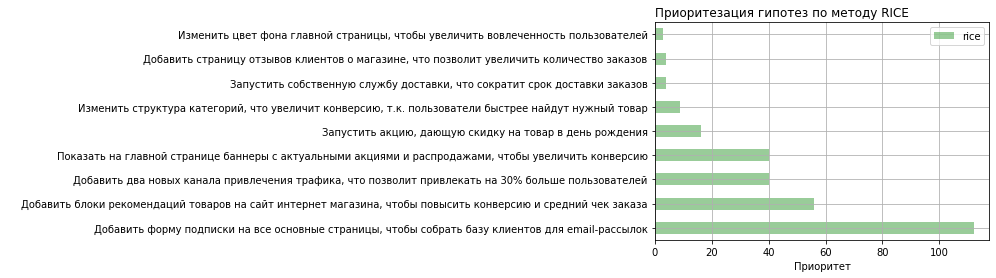

In [12]:
ax = (hypothesis[['hypothesis', 'rice']]
      .set_index('hypothesis')
      .sort_values('rice', ascending=False)
      .plot(kind='barh', color='g', alpha=0.4)
     )
ax.grid(True)
ax.set_xlabel('Приоритет')
ax.set_ylabel(' ')
ax.set_title('Приоритезация гипотез по методу RICE', loc='left')
plt.show()

We see the same hypotheses, only in a different sequence. The difference in priorities is that one takes into account the number of users who will be affected by the changes, while the other does not.

In [13]:
hypothesis[['hypothesis','ice', 'rice']].sort_values(by='rice', ascending=False).head(5)

,hypothesis,ice,rice
7,Добавить форму подписки на все основные страни...,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.200000,16.2


**Conclusion**

According to the ICE framework, hypotheses 8.0 and 7 had the highest scores. After applying the RICE framework, the priorities changed to hypotheses 7.2 and 0. This is because in the case of the ICE framework, unlike RICE, we did not take into account the scope of changes, while this is an important component of the assessment of hypotheses.

In our case, the highest priority hypotheses will be 7, 2, 0.

# **A/B test analysis**

**Cumulative Metrics**

To build graphs based on cumulative data, it is necessary to collect the corresponding aggregated dataframe containing information about the date, group (A or B), the cumulative number of orders and users who placed them, the average check, and, finally, the cumulative number of store visitors.

In [14]:
datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id': 'nunique', 'visitor_id': 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


**Revenue by groups**

We build a graph of cumulative revenue by groups.

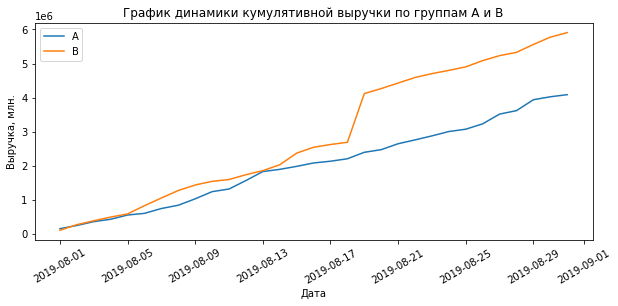

In [15]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График динамики кумулятивной выручки по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xlabel('Дата')
plt.xticks(rotation=30)
plt.legend()
plt.show()

We see that the cumulative revenue of group A grows linearly, and it is less than that of group B.
At the same time, in group B there is a sharp jump around August 18, which may indicate bursts in the number of orders, or the appearance of very expensive orders in the sample.

**Average bill by groups**

We build a graph of the dynamics of the cumulative average check by groups.

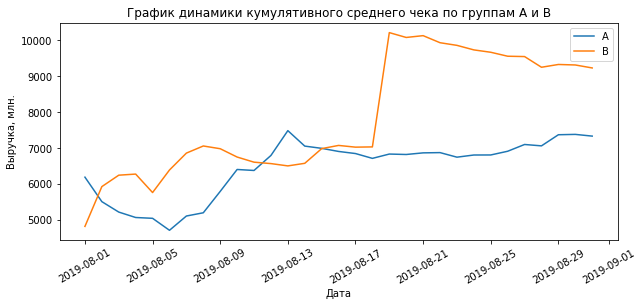

In [16]:
plt.figure(figsize=(10,4))
plt.plot(cumulativeRevenueA['date'], 
         cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'],
         label='A')

plt.plot(cumulativeRevenueB['date'], 
         cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], 
         label='B')
plt.title('График динамики кумулятивного среднего чека по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xlabel('Дата')
plt.xticks(rotation=30)
plt.legend()
plt.show()

We see that the average check in group A stabilized after some time. The average check of group B showed a sharp jump, which speaks in favor of the version of an expensive purchase.

**Relative change in the cumulative average check of group B to group A**

We build a graph of the relative change in the cumulative average check of group B to group A.

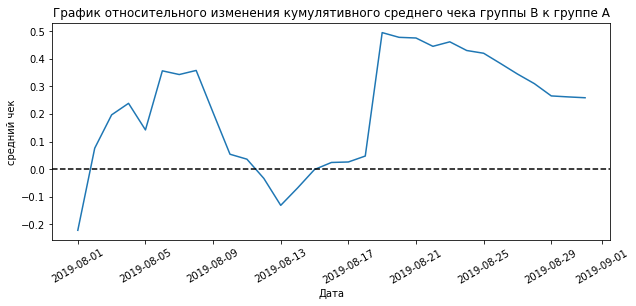

In [17]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(10,4))
plt.plot(mergedCumulativeRevenue['date'], 
         (
             mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']
         )/
         (
             mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']
         )-1
        )

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('средний чек')
plt.xticks(rotation=30)
plt.show()

The chart rises sharply at several points - definitely there are some outliers and large orders.

**Plot the cumulative average orders per visitor by group. Make inferences and assumptions.**


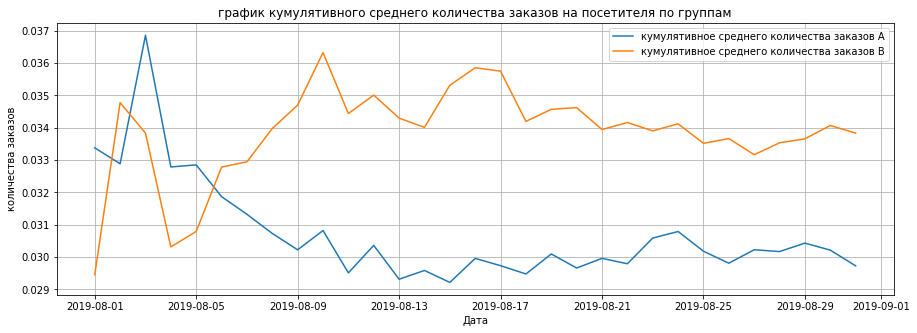

In [18]:
# calculate cumulative conversion
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# separating data by group A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# separating data by group B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# build graphs
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='кумулятивное среднего количества заказов A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='кумулятивное среднего количества заказов B')
plt.xlabel('Дата')
plt.ylabel('количества заказов')
plt.title('график кумулятивного среднего количества заказов на посетителя по группам')
plt.legend();

At the beginning of the month, the cumulative average number of orders in group 'A' was significantly higher, but by the beginning of the second week of the month, the cumulative ones equalized, and group 'B' began to significantly exceed group 'A'. Then, over the course of a month, cumulative in both groups remained practically unchanged.

**Plot the relative change in the cumulative average number of orders per visitor of group B to group A. Draw conclusions and assumptions.**

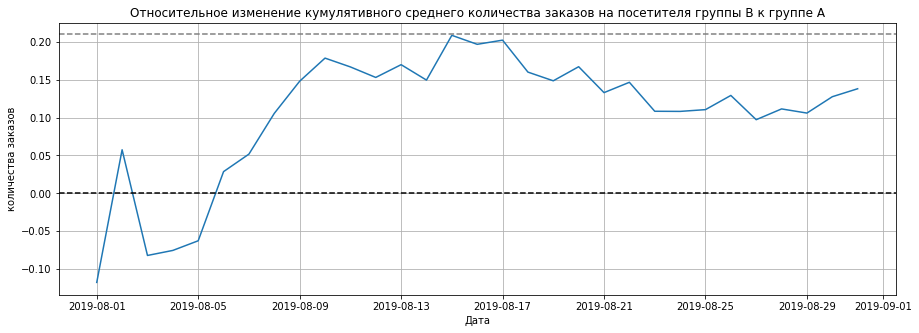

In [19]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


plt.figure(figsize=(15,5))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.xlabel('Дата')
plt.ylabel('количества заказов')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.21, color='grey', linestyle='--');

The conclusions from this graph are very similar to the conclusions from the previous paragraph. At the beginning of the month, the cumulative in group ‘A’ was significantly higher, but by the beginning of the second week of the month, the cumulative became equal. Then, the cumulative in group 'B' became much higher than the cumulative in group 'A' and until the end of the month the averages remained at the same level. The maximum difference in the two groups falls on the 15th of August. On this day, the difference was 21%.

**Plot a scatter plot of the number of orders by user. Make inferences and assumptions.**

Users who have made many orders affect the numerator of the conversion formula (the ratio of the number of orders to the number of visitors to the online store during the test).

A "regular" user rarely makes more than one or two orders in a short time (unless we are talking about sites with regular demand (for example, an online grocery store)). Let's see what happens to the participants of our testing with the number of orders.

count    1031.000000
mean        1.161009
std         0.724919
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: orders, dtype: float64

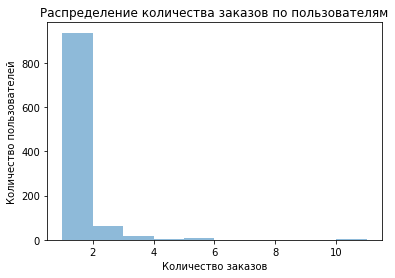

In [20]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns =  ['visitor_id', 'orders']
display(ordersByUsers['orders'].describe())

# building a histogram
plt.hist(ordersByUsers['orders'], alpha=0.5) 
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

Most users placed an order once, but there are those who managed to make eleven orders in a month.

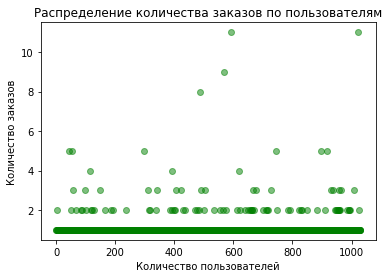

In [21]:
x_values = pd.Series(range(0,len(ordersByUsers)))

# строим точечную диаграмму
plt.scatter(x_values, ordersByUsers['orders'], color='green', alpha=0.5)
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.title('Распределение количества заказов по пользователям')
plt.show()

Many users with 2-3 orders. Their exact proportion is not clear, so it is difficult to understand whether they can be considered outliers or not.
Let's calculate the 95th and 99th percentiles of the number of orders per user and choose a border to identify anomalous users.

In [22]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

No more than 5% of users made more than 2 purchases during testing. And only 1% - four or more.
Let's take 4 orders per user as the upper limit.

**The cost of user orders**

Explore the histogram of the cost of orders.

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

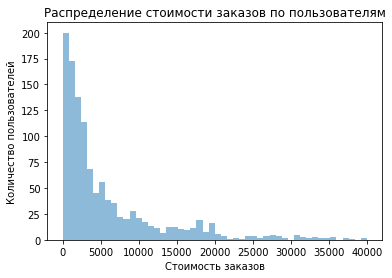

In [23]:
display(orders['revenue'].describe())

# building a histogram
plt.hist(orders['revenue'], alpha=0.5, range=(0,40000),bins = 50) 
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество пользователей')
plt.show()

One of the orders - almost 1.3 million

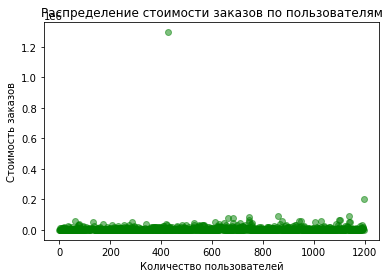

In [24]:
x_values = pd.Series(range(0,len(orders['revenue'])))

# build a scatter chart
plt.scatter(x_values, orders['revenue'], color='green', alpha=0.5)
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')
plt.title('Распределение стоимости заказов по пользователям')
plt.show()

Again we see this giant order that caused a spike in the graphs of cumulative metrics, as well as other significant orders that can affect the result of the research.

We build a similar graph without the two large outliers that we noticed above.

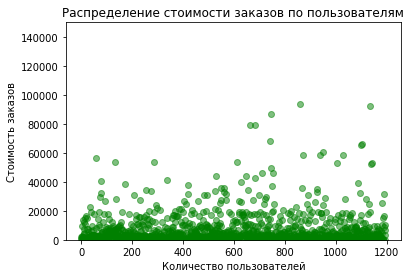

In [25]:
# строим точечную диаграмму
plt.ylim(0, 150000)
plt.scatter(x_values, orders['revenue'], color='green', alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')
plt.show()

We see that the bulk of orders do not exceed 20,000.

Let's calculate the 95th and 99th percentiles of order value per user and choose a boundary to detect anomalies.

In [26]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


We determine the border by the value of the 99% percentile (58233)

**Calculate the statistical significance of differences in the average number of orders per visitor between groups on the raw data. Make inferences and assumptions.**

In [27]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders[orders['group']=='A'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [28]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


We formulate hypotheses that we will refute or confirm further.

H0: There are no statistically significant differences in the average number of orders between groups on the raw data.

H1: There are statistically significant differences in the average number of orders between groups according to raw data.

**We create the ordersByUsersA and ordersByUsersB variables. In them, for users who ordered at least 1 time, we indicate the number of completed orders**

In [29]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

We create variables sample_a and sample_b, in which users from different groups will correspond to the number of orders. Those who did not order anything will be matched with zeros. This is necessary to prepare the samples for verification by the Mann-Whitney test.

In [30]:
sampleA = pd.concat([ordersByUsersA['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitorsPerDateA'].sum() - 
                                          len(ordersByUsersA['orders'])), 
                          name='orders')],axis=0
                    )

sampleB = pd.concat([ordersByUsersB['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitorsPerDateB'].sum() - 
                                          len(ordersByUsersB['orders'])), 
                          name='orders')],axis=0
                    )

In [31]:
print("alpha =",0.05)
print("p-value = {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

alpha = 0.05
p-value = 0.01679
Относительный показатель 'B' и 'A' = 0.138


According to raw data, there are differences between groups.
P-value = 0.01679 is less than 0.05. Hence, we reject the null hypothesis that there are no statistically significant differences between the groups. Group B's relative gain is 13.8%.

**Calculate the statistical significance of differences in the average check of the order between the groups according to the "raw" data. Make inferences and assumptions.**

We formulate hypotheses that we will refute or confirm further.

H0: There are no statistically significant differences in average check between groups based on raw data.

H1: There are statistically significant differences in the average check between groups according to raw data.

In [32]:
print("alpha =",0.05)
print('p-value = {0:.5f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный показатель "B" и "A" = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

alpha = 0.05
p-value = 0.72929
Относительный показатель "B" и "A" = 0.259


p-value is significantly greater than alpha => we do not reject the null hypothesis and can say that there is no difference in the average check.

According to the results of the analysis of raw data, the average checks are similar. At the same time, we also see that the average check in group B is higher than the average check in group A by 25.9%.

**Calculate the statistical significance of the differences in the average number of orders per visitor between groups on the "cleaned" data. Make inferences and assumptions.**

Let's take as abnormal users those who made from 5 orders or made an order more expensive than 58233. So we will remove 1% of users with the largest number of orders and from 1% of users with expensive orders. Let's make cuts of users with more than 4 orders - users_with_many_orders and users who made orders more than 58233 - users_with_expensive_orders. Let's combine them in the abnormal_users table.
Find out how many anomalous users there are using the shape() method.

In [33]:
many_orders = np.percentile(ordersByUsers['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)


users_with_many_orders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > many_orders]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > many_orders]['visitor_id'],
    ],
    axis=0,
)


users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']


abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(5))
abnormal_users.shape[0]

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

15

There are 15 anomalous users in total.

Let's find out how their actions influenced the test results. Let's calculate the statistical significance of the differences in conversion between test groups based on the cleaned data. First, let's prepare samples of the number of orders by users by test groups.

We formulate hypotheses that we will refute or confirm further.

H0: There are no statistically significant differences in average bookings per visitor between groups on the cleaned data.

H1: There are statistically significant differences in the average number of orders per visitor between the groups based on the cleaned data.

In [34]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [35]:
print("alpha =",0.05)
print('p-value = {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный показатель "B" и "A" = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

alpha = 0.05
p-value = 0.01438
Относительный показатель "B" и "A" = 0.153


p-value is less than alpha => we reject the null hypothesis.

There are statistically significant differences between the groups.

This means that, as in the raw data, there are differences between the groups in the cleaned data.

The relative superiority of group "B" over "A" is 15.3% (higher than with "raw" data).

**Calculate the statistical significance of the differences in the average check of the order between the groups according to the "cleaned" data. Make inferences and assumptions.**

We formulate hypotheses that we will refute or confirm further.

H0: There are no statistically significant differences in the average check between groups based on the cleaned data.

H1: There are statistically significant differences in the average check between groups according to raw data.

In [36]:
print("alpha =",0.05)

print(
    'p-value = {0:.5f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный показатель 'B' и 'A' = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

alpha = 0.05
p-value = 0.85091
Относительный показатель 'B' и 'A' = -0.006


P-value is significantly greater than 0.05. This means that there is no reason to reject the null hypothesis and believe that there are differences in the average bill. There are practically no differences in the difference between the average checks of the groups.

# Сonclusions

Based on the input data provided by the online store, a study was conducted and the recommendations set out below were made.

**1. In terms of prioritizing hypotheses from the list provided by the Marketing Department, you should first of all pay attention to the following hypotheses:**

* "Start a promotion that gives a discount on a product on your birthday",
* "Add two new channels to attract traffic, which will attract 30% more users",
* "Add a subscription form to all main pages to build a customer base for email newsletters";

If the ranking of hypotheses should also include the coverage of online store users, then the places must be distributed in the following way:

* "Add a subscription form to all main pages to build a customer base for email newsletters",
* "Add blocks of product recommendations to the website of the online store to increase the average check of the order",
* "Add two new traffic acquisition channels to reach 30% more users."

**2. Regarding the analysis of the A / B test:**

* There is a statistically significant difference between the groups both in terms of raw data and data after anomaly filtering. The indicators of group B are higher than in A by 14-15%;

* There is no statistically significant difference in the average check between the groups, either according to the "raw" or according to the data after filtering out the anomalies;

* The graph of the relative change of group B to group A shows that the results of group B are consistently better than group A;

Based on the above, we recommend stopping the test, fixing the victory of group B.